In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, FactorAnalysis
import plotly.graph_objects as go
import scipy.cluster.hierarchy as sch
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, silhouette_score
import seaborn as sns
from sklearn.pipeline import Pipeline

georgia_font = {'fontname': 'Georgia'}
calibri_font = {'fontname': 'Calibri'}

In [3]:
df = pd.read_csv('out.csv')
df.isna().sum()

Track                            0
Album Name                       0
Artist                           5
Release Date                     0
ISRC                             0
All Time Rank                    0
Track Score                      0
Spotify Streams                113
Spotify Playlist Count          70
Spotify Playlist Reach          72
Spotify Popularity             804
YouTube Views                  308
YouTube Likes                  315
TikTok Posts                  1173
TikTok Likes                   980
TikTok Views                   981
YouTube Playlist Reach        1009
Apple Music Playlist Count     561
AirPlay Spins                  498
SiriusXM Spins                2123
Deezer Playlist Count          921
Deezer Playlist Reach          928
Amazon Playlist Count         1055
Pandora Streams               1106
Pandora Track Stations        1268
Soundcloud Streams            3333
Shazam Counts                  577
TIDAL Popularity              4600
Explicit Track      

In [4]:
df['Release Date']=pd.to_datetime(df['Release Date'], format = "%m/%d/%Y")


df['Explicit Track']= df['Explicit Track'].astype(bool)
df.drop(['TIDAL Popularity', 'Soundcloud Streams'], axis=1, inplace=True)



strings_to_nums = df[['Spotify Streams', 'Track Score', 'All Time Rank','Spotify Playlist Count','Spotify Playlist Reach','YouTube Views','YouTube Likes', 'TikTok Posts', 'Apple Music Playlist Count', 'Deezer Playlist Count', 'Amazon Playlist Count', 'Spotify Popularity', 'TikTok Likes','TikTok Views','YouTube Playlist Reach','AirPlay Spins','SiriusXM Spins','Deezer Playlist Reach','Pandora Streams','Pandora Track Stations','Shazam Counts']].replace(',', '', regex=True).fillna(0)
strings_to_nums = strings_to_nums.apply(pd.to_numeric, args =('coerce','integer'))

df[['Spotify Streams', 'Track Score', 'All Time Rank','Spotify Playlist Count','Spotify Playlist Reach','YouTube Views','YouTube Likes','TikTok Posts', 'Apple Music Playlist Count', 'Deezer Playlist Count', 'Amazon Playlist Count', 'Spotify Popularity', 'TikTok Likes','TikTok Views','YouTube Playlist Reach','AirPlay Spins','SiriusXM Spins','Deezer Playlist Reach','Pandora Streams','Pandora Track Stations','Shazam Counts']] = strings_to_nums

df['key'] = df['key'].fillna('missing_key')


In [5]:
import ast
lst = [ast.literal_eval(e) for e in df['Artist Genre']]
df['Artist Genre'] = lst

In [6]:
discrete = []
continuous = []

for col in df.columns:
    if col == 'All Time Rank' or col == 'Track Score': continue
    if df[col].dtype == np.int8 or df[col].dtype == np.int16 or df[col].dtype == np.int32 or df[col].dtype == np.int64:
        discrete.append(col)
    elif df[col].dtype == np.float64:
        continuous.append(col)
        


In [7]:
df['Year'] = df['Release Date'].dt.year
df['Month'] = df['Release Date'].dt.month
df['Day'] = df['Release Date'].dt.day
for (idx, e) in enumerate(df['Release Date']):
    assert(e.year == df['Year'][idx])
    assert(e.month == df['Month'][idx])
    assert(e.day == df['Day'][idx])
df = df.drop(columns=['Track', 'Album Name', 'Artist Genre', 'All Time Rank', 'Artist', 'ISRC', 'Spotify ID', 'Spotify Popularity', 'Track Score', 'Spotify Playlist Count', 'Spotify Playlist Reach', 'YouTube Likes', 'TikTok Posts', 'TikTok Likes', 'YouTube Playlist Reach', 'Deezer Playlist Reach', 'Pandora Track Stations', 'Day', 'Month'])

In [8]:
freq_year = {}
for (idx, e) in enumerate(df['Year']):
    try:
        freq_year[e] += 1
    except:
        freq_year[e] = 0
        freq_year[e]+=1
        
freq_year

{2024: 693,
 2023: 1158,
 2022: 694,
 2021: 408,
 2015: 96,
 2019: 296,
 2017: 213,
 2020: 360,
 2018: 249,
 2016: 123,
 2011: 51,
 2013: 55,
 2014: 70,
 2012: 47,
 2010: 27,
 2009: 15,
 2000: 2,
 2005: 5,
 2004: 5,
 1994: 1,
 2008: 11,
 2002: 5,
 2007: 5,
 2003: 3,
 2006: 3,
 1999: 1,
 1987: 1,
 1998: 1,
 2001: 1,
 1991: 1}

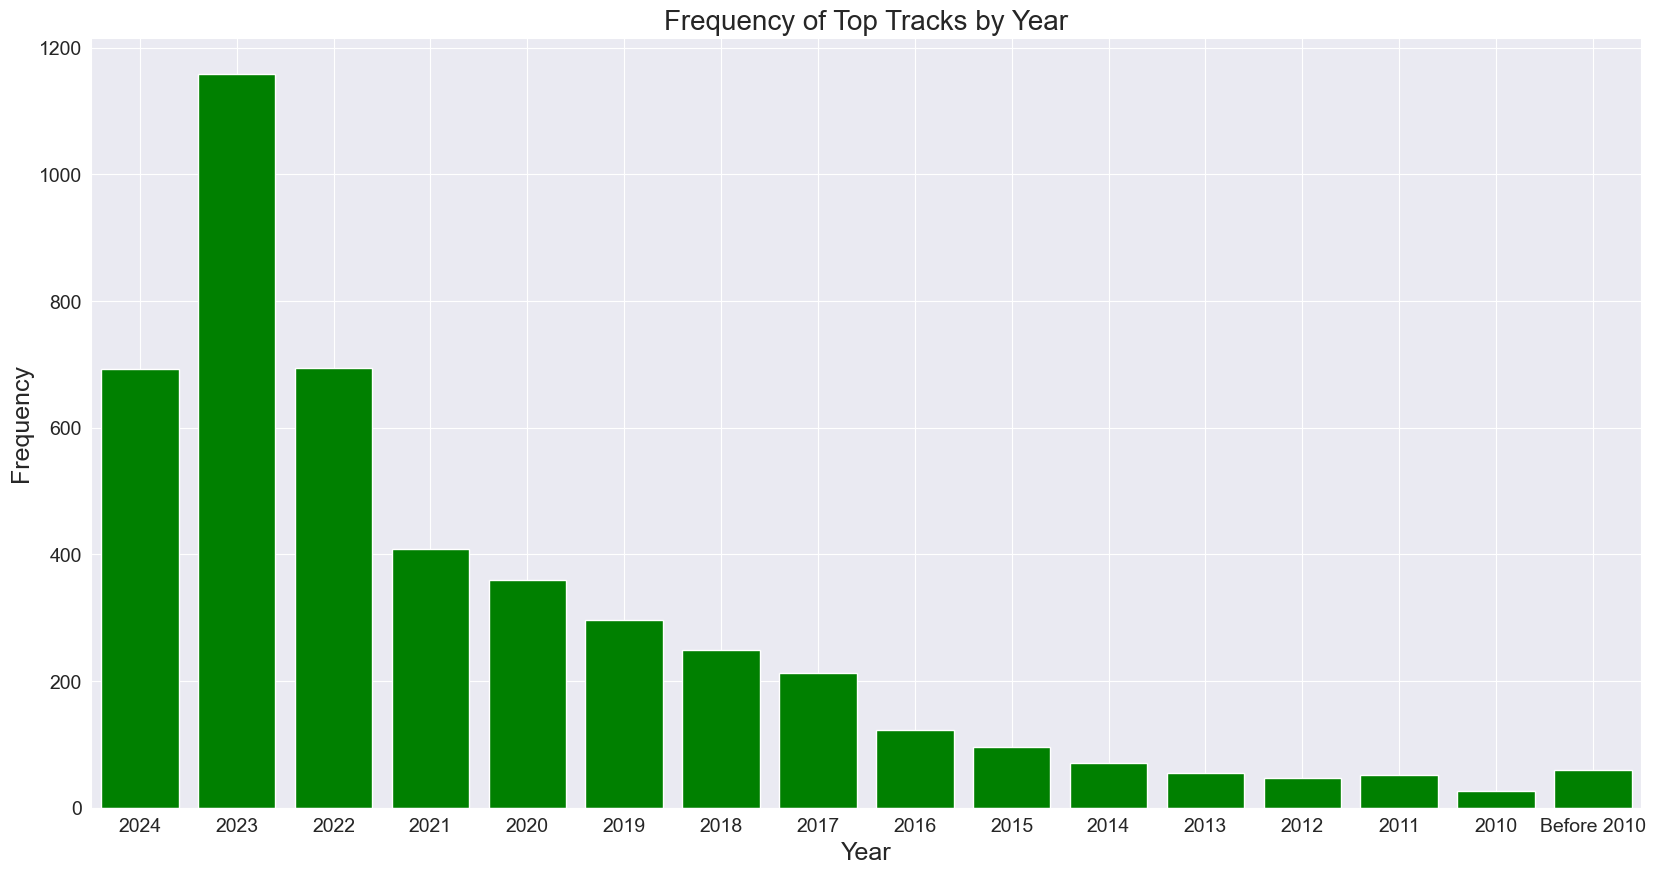

In [9]:
grouped_freq_year = {}

sum_before_2010 = sum(value for year, value in freq_year.items() if year < 2010)

for year in reversed(sorted(year for year in freq_year if year >= 2010)):
    grouped_freq_year[year] = freq_year[year]
grouped_freq_year['Before 2010'] = sum_before_2010


keys = list(grouped_freq_year.keys())
values = list(grouped_freq_year.values())

plt.figure(figsize=(20, 10))
plt.bar(range(len(keys)), values, color='g')
plt.xticks(range(len(keys)), labels=keys, fontsize=13)
plt.xlabel('Year', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.title('Frequency of Top Tracks by Year', fontsize=20)

plt.tick_params(axis='both', labelsize=14)
plt.xlim(-0.5, len(keys) - 0.5)
plt.savefig('Graphs/tracks-per-year.png', bbox_inches='tight', transparent=True)



In [10]:
df['Year'] = df['Year'].mask(df['Year'] < 2018, '<2018')
df['Year'] = df['Year'].replace({2018: '2018-2023', 2019: '2018-2023', 2020: '2018-2023', 2021: '2018-2023', 2022: '2018-2023'})

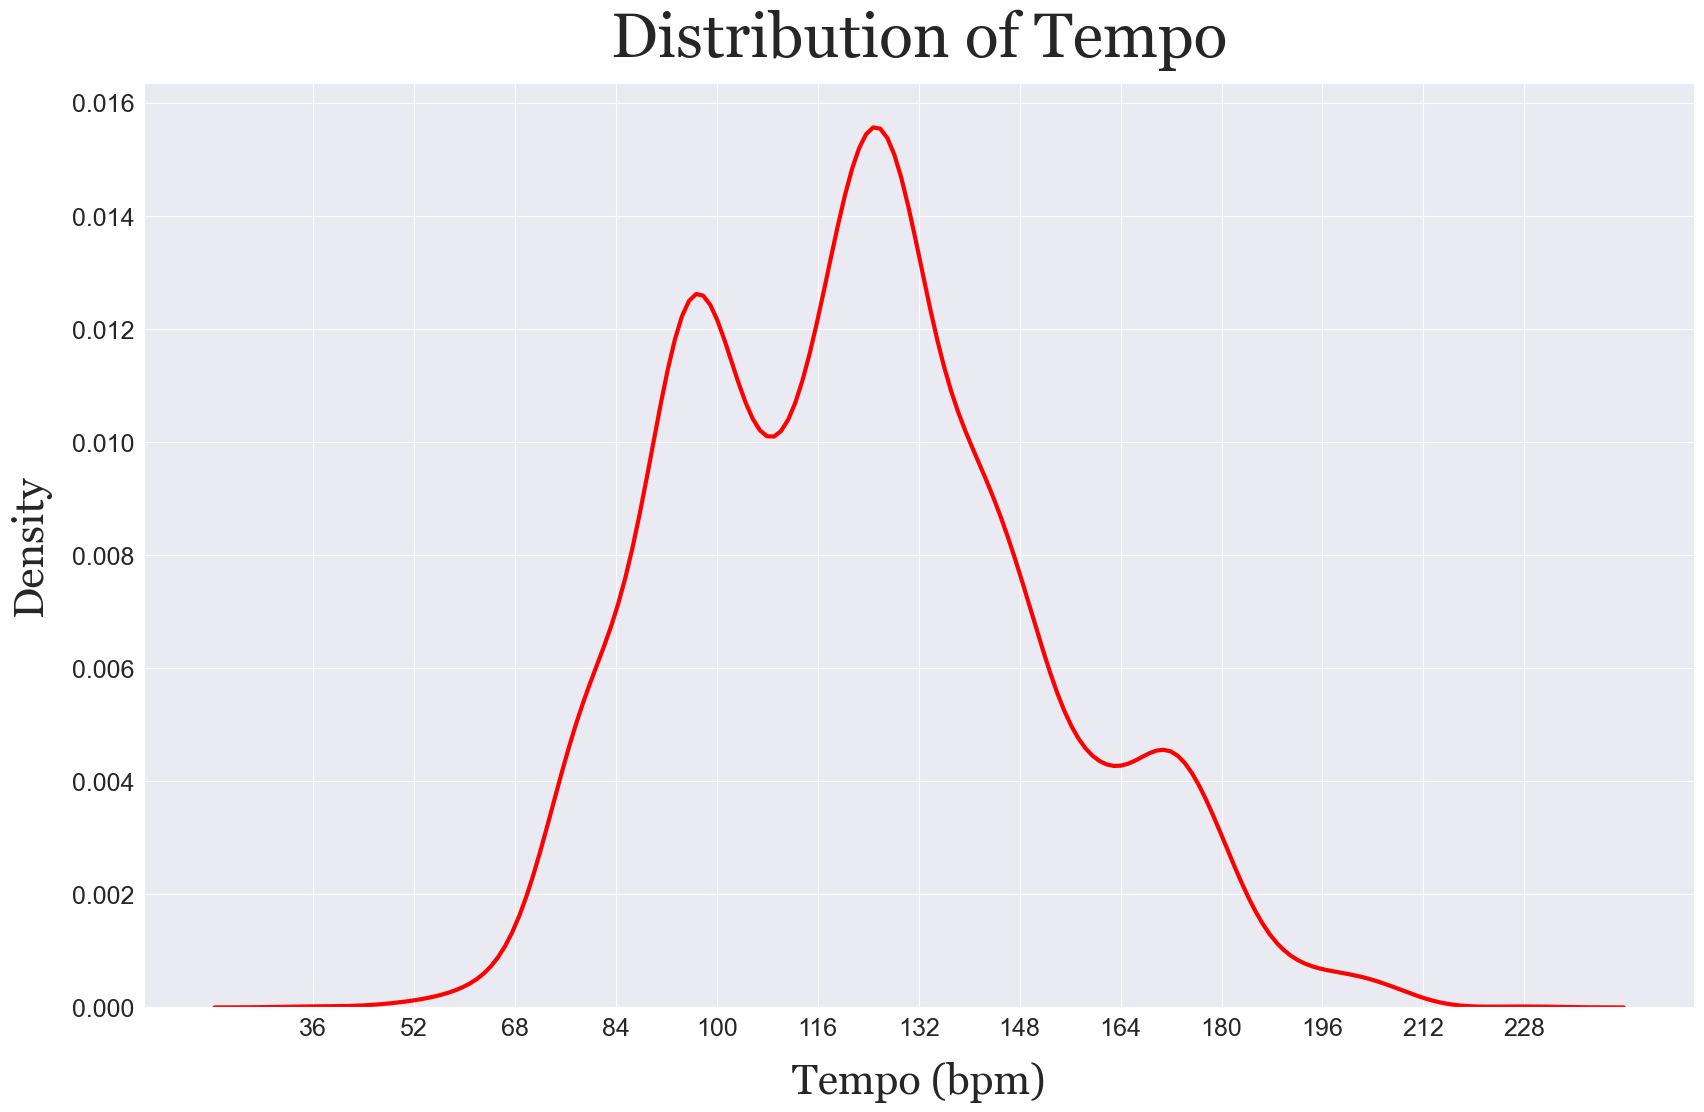

In [11]:
plt.figure(figsize=(20, 12))
sns.kdeplot(df['tempo'], color='red', lw=3)
plt.xticks(np.linspace(int(df['tempo'].min()), int(df['tempo'].max()), num=13))
plt.grid(True)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Tempo (bpm)', fontsize=30, labelpad=15, **georgia_font)
plt.ylabel('Density', fontsize=30, labelpad=15, **georgia_font)
plt.title('Distribution of Tempo', fontsize=45, y=1.02, **georgia_font)

plt.savefig('Graphs/distrib-tempo.png', bbox_inches='tight', transparent=True)

In [12]:
tempo_intvs = [0, 66, 80, 108, 120, 156, float('inf')]
labels = ['0-66', '66-80', '80-108', '108-120', '120-156', '156+']
df['tempo'] = pd.cut(df['tempo'], bins=tempo_intvs, labels=labels, right=False)

In [13]:
df = pd.get_dummies(data=df, columns=['tempo'], drop_first=True, dtype=int)
df = pd.get_dummies(data=df, columns=['Year'], prefix='Released', drop_first=True, dtype=int)
df = pd.get_dummies(data=df, columns=['key'], prefix='Key', drop_first=True, dtype=int)
df = pd.get_dummies(data=df, columns=['mode'], prefix='Mode', drop_first=True, dtype=int)
df = pd.get_dummies(data=df, columns=['time_signature'], prefix='TimeSignature', drop_first=True, dtype=int)

df = df.drop('Release Date', axis=1)

In [14]:
dummified = df
dummified.columns

Index(['Spotify Streams', 'YouTube Views', 'TikTok Views',
       'Apple Music Playlist Count', 'AirPlay Spins', 'SiriusXM Spins',
       'Deezer Playlist Count', 'Amazon Playlist Count', 'Pandora Streams',
       'Shazam Counts', 'Explicit Track', 'acousticness', 'danceability',
       'duration_ms', 'energy', 'instrumentalness', 'loudness', 'speechiness',
       'valence', 'liveness', 'tempo_66-80', 'tempo_80-108', 'tempo_108-120',
       'tempo_120-156', 'tempo_156+', 'Released_2024', 'Released_2018-2023',
       'Released_<2018', 'Key_1.0', 'Key_2.0', 'Key_3.0', 'Key_4.0', 'Key_5.0',
       'Key_6.0', 'Key_7.0', 'Key_8.0', 'Key_9.0', 'Key_10.0', 'Key_11.0',
       'Mode_1.0', 'TimeSignature_3.0', 'TimeSignature_4.0',
       'TimeSignature_5.0'],
      dtype='object')

In [15]:
# Index(['Spotify Streams', 'YouTube Views', 'TikTok Views',
#        'Apple Music Playlist Count', 'AirPlay Spins', 'SiriusXM Spins',
#        'Deezer Playlist Count', 'Amazon Playlist Count', 'Pandora Streams',
#        'Shazam Counts', 'Explicit Track', 'acousticness', 'danceability',
#        'duration_ms', 'energy', 'instrumentalness', 'loudness', 'speechiness',
#        'valence', 'liveness', 'tempo_66-80', 'tempo_80-108', 'tempo_108-120',
#        'tempo_120-156', 'tempo_156+', 'Released_2024', 'Released_2018-2023',
#        'Released_<2018', 'Key_1.0', 'Key_2.0', 'Key_3.0', 'Key_4.0', 'Key_5.0',
#        'Key_6.0', 'Key_7.0', 'Key_8.0', 'Key_9.0', 'Key_10.0', 'Key_11.0',
#        'Mode_1.0', 'TimeSignature_3.0', 'TimeSignature_4.0',
#        'TimeSignature_5.0'],
#       dtype='object')

In [16]:
sc = StandardScaler()
to_scale = ['Spotify Streams', 'YouTube Views', 'TikTok Views', 'Apple Music Playlist Count', 'AirPlay Spins', 'SiriusXM Spins', 'Deezer Playlist Count', 'Amazon Playlist Count', 'Pandora Streams', 'Shazam Counts', 'acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'loudness', 'speechiness', 'valence', 'liveness']

X = dummified.copy()
X[to_scale] = sc.fit_transform(X[to_scale])

X.head()

,Spotify Streams,YouTube Views,TikTok Views,Apple Music Playlist Count,AirPlay Spins,SiriusXM Spins,Deezer Playlist Count,Amazon Playlist Count,Pandora Streams,Shazam Counts,...,Key_6.0,Key_7.0,Key_8.0,Key_9.0,Key_10.0,Key_11.0,Mode_1.0,TimeSignature_3.0,TimeSignature_4.0,TimeSignature_5.0
0,-0.085648,-0.425406,0.843630,2.333969,-0.067176,1.278149,0.719936,3.751739,-0.312101,0.080119,...,0,0,0,0,0,0,0,0,1,0
1,-0.210162,-0.378609,-0.134635,2.017120,-0.068791,-0.317704,0.819490,3.632591,-0.379903,-0.191580,...,0,0,0,0,0,0,1,0,1,0
2,0.307545,-0.369486,0.468823,2.045924,0.206274,0.931326,2.193328,6.055251,-0.398188,0.538400,...,0,0,0,0,0,1,1,0,1,0
3,2.974303,1.050957,2.613738,4.983979,11.686490,4.788556,4.741898,7.564450,0.830166,1.683648,...,0,0,0,0,0,0,1,0,1,0
4,-0.614229,-0.435475,-0.174411,1.930706,-0.303180,-0.322391,1.118150,3.394297,-0.401694,-0.307419,...,0,0,0,1,0,0,0,0,1,0


In [17]:
# corr = X.corr().round(2)
# mask = np.triu(np.ones_like(corr, dtype=bool))
# plt.figure(figsize=(80, 67))
# sns.heatmap(corr, mask=mask, cmap='coolwarm', fmt='.2f', annot=True, annot_kws={"fontsize": 32})
# plt.xticks(fontsize=42)
# plt.yticks(fontsize=42, rotation=0)
# 
# plt.savefig('Graphs/giant-corr-matrix(JOKE).png', bbox_inches='tight', transparent=True)

In [18]:
wcss = []
silhouette_avg = []
for n in range(1, 11):
    kmeans = KMeans(n_clusters=n, init='k-means++', random_state=1)
    kmeans.fit(X)
    labels = kmeans.labels_
    wcss.append(kmeans.inertia_)
    if n != 1:
        silhouette_avg.append(silhouette_score(X, labels))

C:\Users\boz42\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\boz42\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\boz42\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\boz42\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\boz42\anaconda3\Lib\site-packages\sklearn\clust

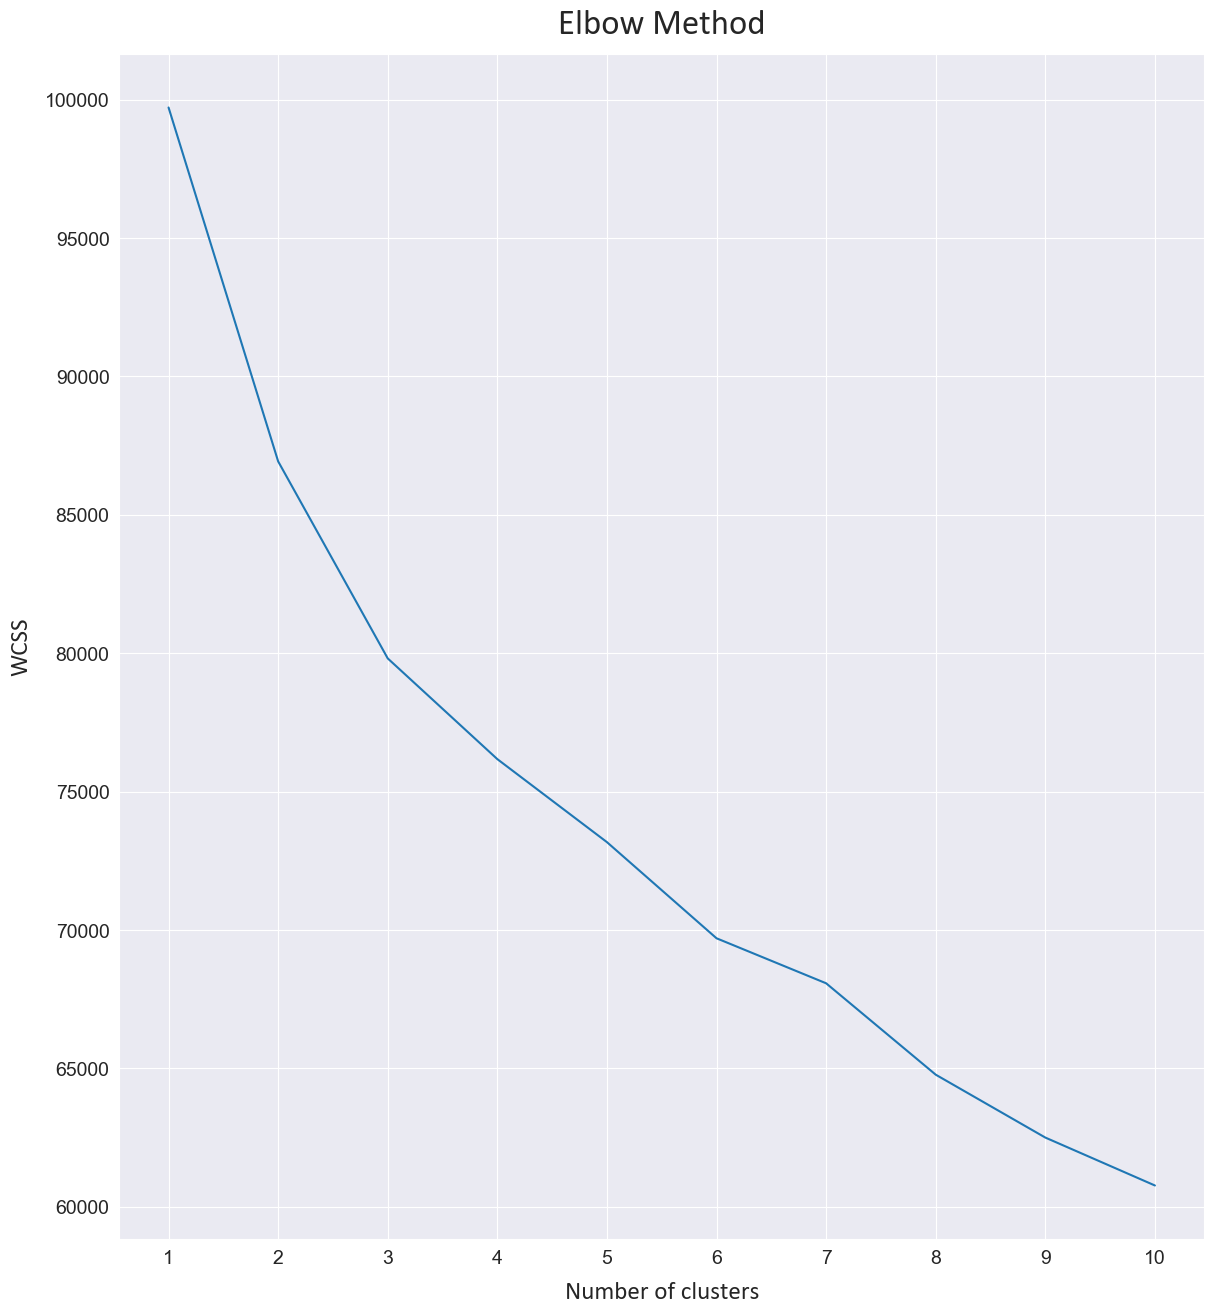

In [19]:
# Process
plt.figure(figsize=(14, 15.4))
plt.plot(range(1, 11), wcss)
plt.xticks(np.arange(1, 11), fontsize=14)
plt.yticks(fontsize=14)
plt.title('Elbow Method', **calibri_font, fontsize=25, y=1.01)
plt.xlabel('Number of clusters', **calibri_font, fontsize=18, labelpad=10)
plt.ylabel('WCSS', **calibri_font, fontsize=18, labelpad=10)

plt.grid(True)

plt.savefig('Graphs/elbow-method', bbox_inches='tight', transparent=False)

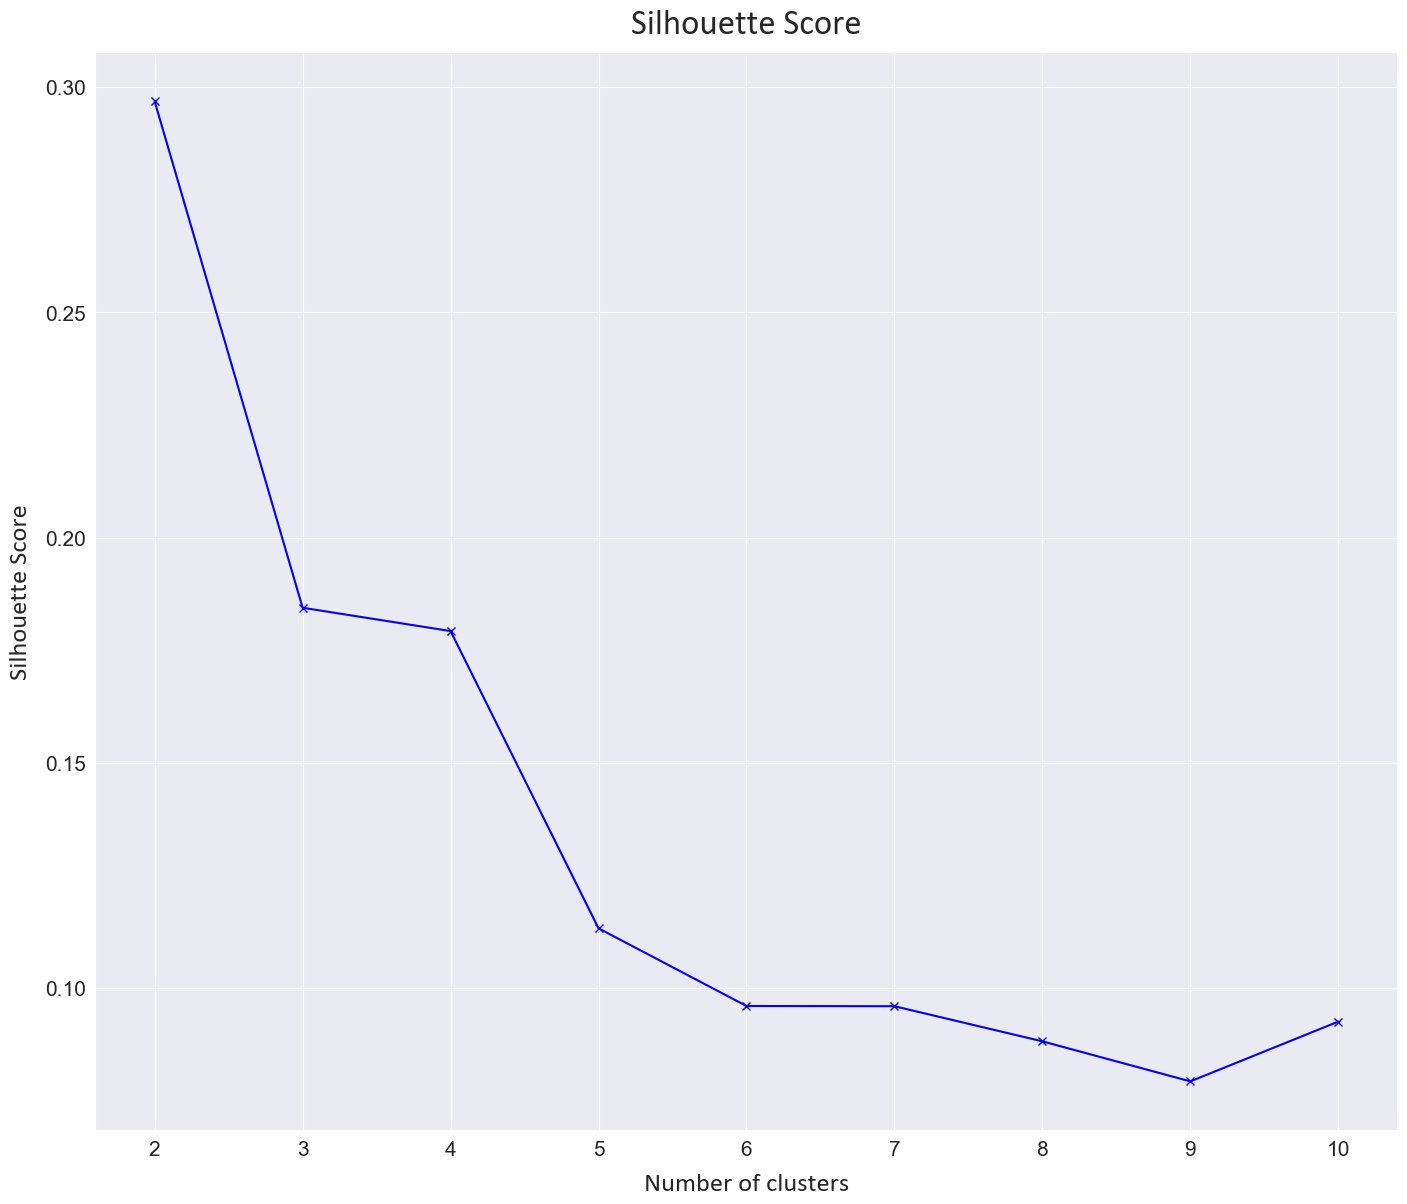

In [20]:
# Process
plt.figure(figsize=(16.8, 14))
plt.plot(range(2, 11), silhouette_avg, 'bx-')
plt.title('Silhouette Score', **calibri_font, fontsize=25, y=1.01)
plt.xlabel('Number of clusters', **calibri_font, fontsize=19, labelpad=10)
plt.ylabel('Silhouette Score', **calibri_font, fontsize=19, labelpad=10)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.grid(True)

plt.savefig('Graphs/silhouette-score', bbox_inches='tight', transparent=False)

# Interesting clusters at 6

#### 6 clusters

In [21]:
n = 6
kmeans = KMeans(n_clusters = n, init = 'k-means++', random_state = 1)
kmeans.fit(X)
labels = kmeans.labels_

X_labeled = np.column_stack((X, labels))

cluster_averages = []
for cluster in range(n):
    cluster_data = X_labeled[X_labeled[:, -1] == cluster, :-1]
    cluster_avg = np.mean(cluster_data, axis=0)
    cluster_averages.append(cluster_avg)

cluster_df = pd.DataFrame(cluster_averages, columns=[f"Feature {i+1}" for i in range(X.shape[1])])

cluster_df["Cluster"] = [f"Cluster {i}" for i in range(1, n + 1)]
cluster_df.set_index("Cluster", inplace=True)
cluster_df.columns = X.columns.tolist()


C:\Users\boz42\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


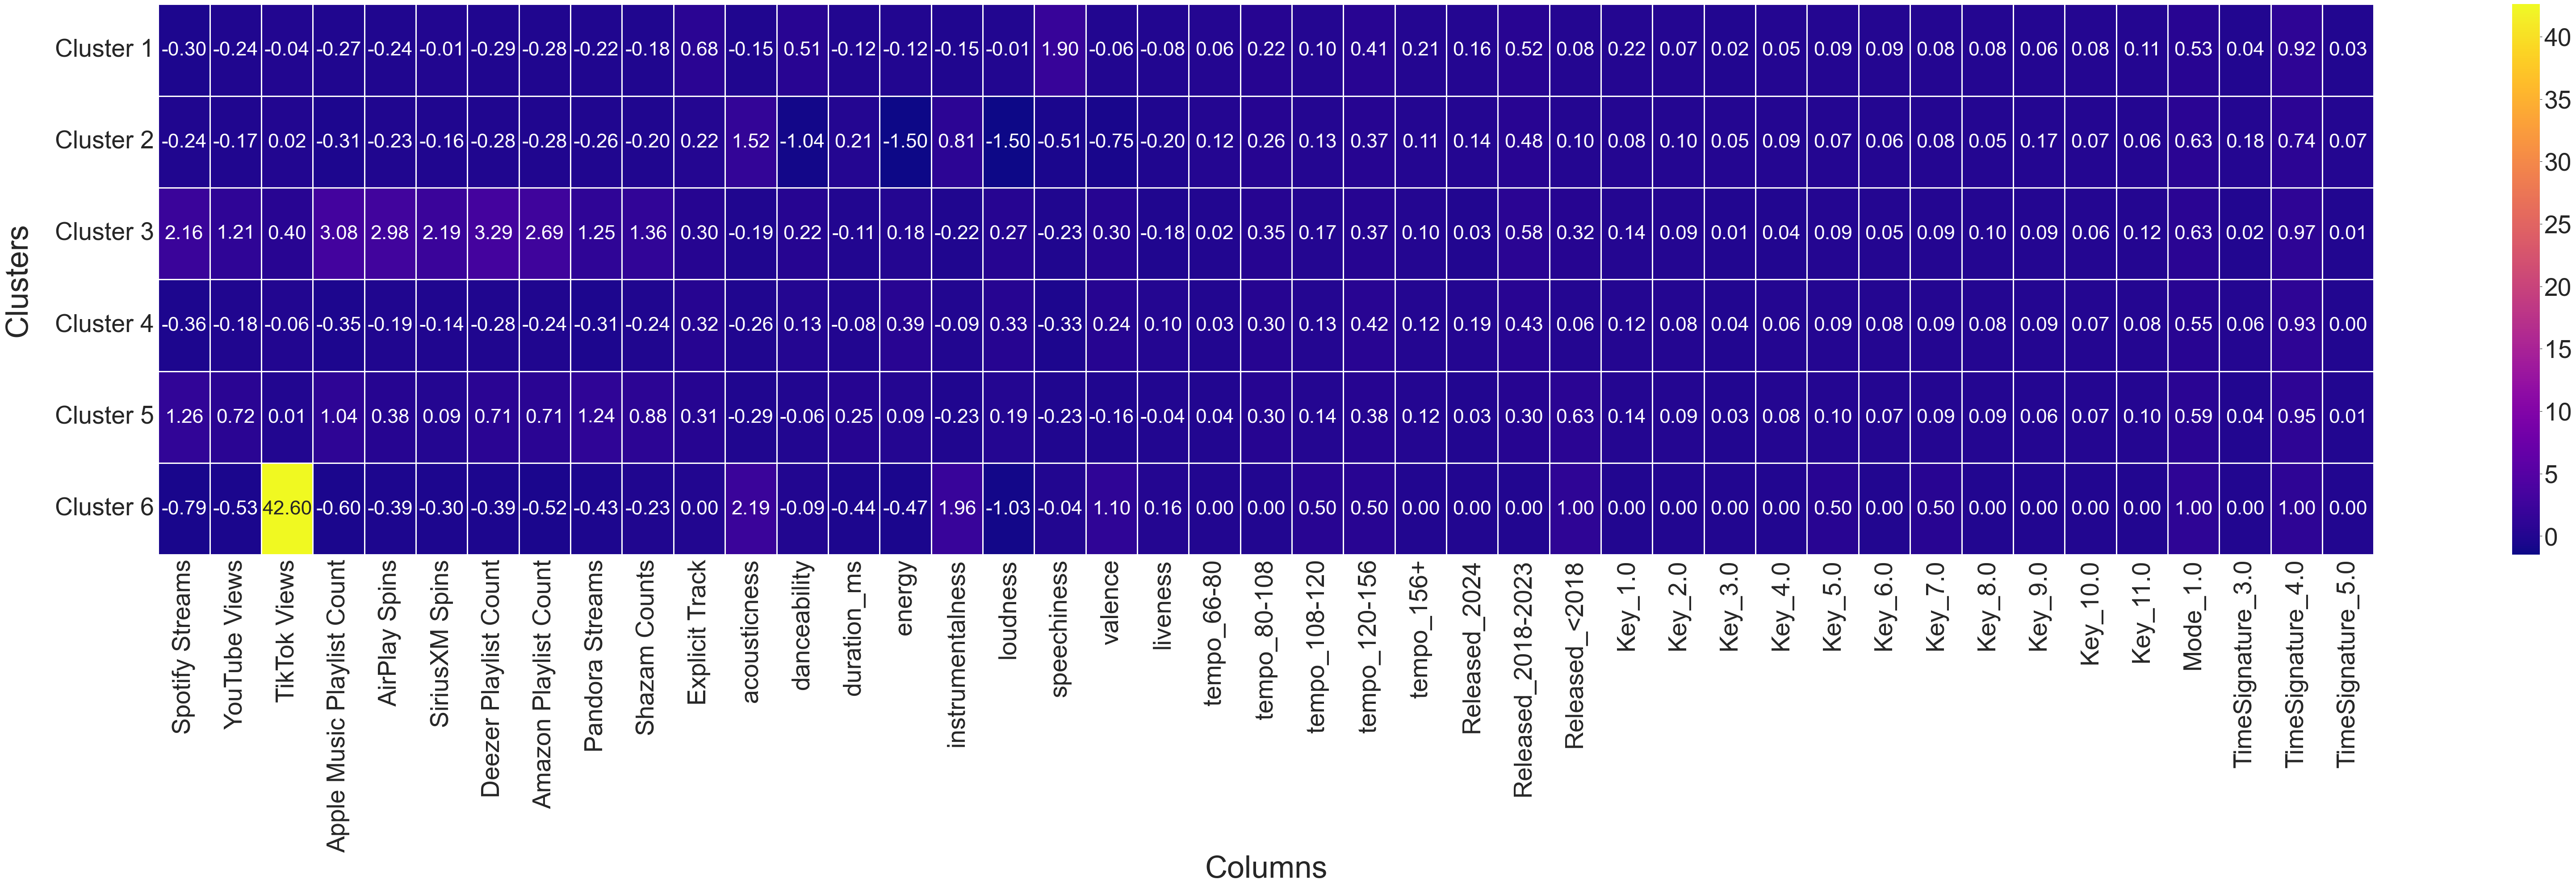

In [22]:
plt.figure(figsize=(80, 16))
ax = sns.heatmap(cluster_df, annot=True, linewidths=1, cmap='plasma', fmt='.2f', annot_kws={'fontsize': 32})
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=40)

plt.xlabel('Columns', fontsize=50)
plt.ylabel('Clusters', fontsize=50, labelpad=35)

plt.xticks(fontsize=40)
plt.yticks(fontsize=40, rotation=0)

plt.savefig('Graphs/clusters.png', bbox_inches='tight', transparent=True)

In [23]:
cluster_df[to_scale] = sc.inverse_transform(cluster_df[to_scale])
cluster_df = pd.DataFrame(cluster_df, columns=X.columns.tolist(), index=[f'Cluster {i}' for i in range(1, n+1)])

cluster_df.round(2)

,Spotify Streams,YouTube Views,TikTok Views,Apple Music Playlist Count,AirPlay Spins,SiriusXM Spins,Deezer Playlist Count,Amazon Playlist Count,Pandora Streams,Shazam Counts,...,Key_6.0,Key_7.0,Key_8.0,Key_9.0,Key_10.0,Key_11.0,Mode_1.0,TimeSignature_3.0,TimeSignature_4.0,TimeSignature_5.0
Cluster 1,2.753612e+08,2.135416e+08,6.803298e+08,29.30,19520.37,135.93,11.06,12.41,3.261394e+07,1172187.11,...,0.09,0.08,0.08,0.06,0.08,0.11,0.53,0.04,0.92,0.03
Cluster 2,3.102303e+08,2.622641e+08,1.011434e+09,26.75,21001.95,68.55,11.86,12.54,2.654338e+07,1074395.89,...,0.06,0.08,0.05,0.17,0.07,0.06,0.63,0.18,0.74,0.07
Cluster 3,1.593489e+09,1.205444e+09,3.030624e+09,261.80,412101.73,1074.92,191.25,87.30,2.531450e+08,9966572.29,...,0.05,0.09,0.10,0.09,0.06,0.12,0.63,0.02,0.97,0.01
Cluster 4,2.431508e+08,2.538676e+08,5.973466e+08,23.30,25847.35,78.83,11.86,13.53,1.894364e+07,849500.39,...,0.08,0.09,0.08,0.09,0.07,0.08,0.55,0.06,0.93,0.00
Cluster 5,1.114455e+09,8.724465e+08,9.839338e+08,120.08,95769.37,179.09,61.49,37.43,2.514477e+08,7227473.45,...,0.07,0.09,0.09,0.06,0.07,0.10,0.59,0.04,0.95,0.01
Cluster 6,1.390205e+07,9.530248e+06,2.240381e+11,6.50,1386.00,8.50,6.50,6.50,5.371900e+04,905119.50,...,0.00,0.50,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00


# Clusters

Cluster 1: **Rap:** Relatively low radio and playlist count. High explicit, low acousticness. High danecability, median length, high energy. No instrumentalness. High speechiness, fast tempo. Released 2018-2023. Lowest percentage of major key.

Cluster 2: **Acoustics, movie soundtracks?** Moderate-high acousticness. Not very explicit. Medium length, low energy. Loud,, but low speechiness, danceability. Low valence, liveness. Moderate-fast tempo. Released 2018-2023. A major(string instruments?).

Cluster 3: **Radio hits, old classics:** High streams/views across the board. Big radio coverage("spins"). High Shazam Counts, low explilcits. High energy, danceability, medium duration. Low loudness, high valence. Moderate tempo. Released 2018-2023

Cluster 4: **Upbeat and Catchy(just gets people in a good mood)** Slighly lower on charts and playlist count. Low explicits, high danceability. Medium duration. High energy, quick tempo. Released 2018-2023. 

Cluster 5: **Personal playlist hits(Balanced) + Throwback** Well-performing on tracks, high playlist counts. A lot of overlap, similar characteristics with Cluster 3. 

Cluster 6: **TikTok stars:** Extremely low on charts and playlist count, except for TikTok. Apparently *no explicits*, but that might be a flaw in the dataset. High acousticness, danceability, instrumentalness, liveness, valence. Low speechiness. Moderate-fast tempo. Released <2018. F and G majors most common. 